### mol_rnn model (hasRing data) -- keras

In [1]:
import numpy as np
from Teemo.utils import fileops
from Teemo.algorithm.utils import matrixops
from collections import Counter
from assertpy import assert_that
import getpass
import os
from Teemo.examples.mol_rnn import one_smiles

### prepare training data

In [3]:
def prepare_data(num_mols):
    '''
    return list of 1D numpy.ndarray
    '''
    data_dir = '/home/'+getpass.getuser()+'/git_test/test_data/examples/has_ring/alogps/'
    smiles_file = data_dir + 'alogps.smi'
    hasRing_file = data_dir + 'alogps.hasring'
    assert os.path.exists(smiles_file), os.path.exists(hasRing_file)

    smiles_data = [x[0] for x in fileops.read_file(smiles_file)][:num_mols]
    hasRing_data = [int(x[0]) for x in fileops.read_file(hasRing_file)][:num_mols]
    print (Counter(hasRing_data))

    hasRing_data = np.eye(2)[np.asarray(hasRing_data)]

    x_bond = []
    x_atom = []
    for sm in smiles_data:
        mol_chain = one_smiles.convert_mol_graph_to_chain(sm)['mol_chain']
        mol_seq = []
        for item in mol_chain.values():
            mol_seq.extend(item['chain_values'])
        x_bond.append(np.asarray([x[0] for x in mol_seq]))
        x_atom.append(np.asarray([x[1] for x in mol_seq]))

    num_train = int(num_mols * 0.8)
    num_valid = num_mols - num_train
    all_idx = np.random.choice(np.arange(num_mols), num_mols, replace=False)
    train_idx = all_idx[:num_train]
    valid_idx = all_idx[num_train:]

    train_x_bond = [x_bond[ii] for ii in train_idx]
    train_x_atom = [x_atom[ii] for ii in train_idx]
    train_y = [hasRing_data[ii] for ii in train_idx]

    valid_x_bond = [x_bond[ii] for ii in valid_idx]
    valid_x_atom = [x_atom[ii] for ii in valid_idx]
    valid_y = [hasRing_data[ii] for ii in valid_idx]

    return train_x_bond, train_x_atom, train_y, valid_x_bond, valid_x_atom, valid_y

num_mols = 100
train_x_bond, train_x_atom, train_y, valid_x_bond, valid_x_atom, valid_y = prepare_data(num_mols)
print (len(train_x_bond), np.mean([len(x) for x in train_x_bond]))
print ('prepare data already')

Counter({1: 53, 0: 47})
(80, 88.137500000000003)
prepare data already


### build model

In [3]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Merge
from keras.optimizers import SGD
def build_model():
    bond_voca_size, atom_voca_size = 23, 100 
    bond_emb_dim, atom_emb_dim = 200, 200 
    lstm_hidden_dim = 150
    output_dim = 2
    branch_1 = Sequential()
    branch_1.add(Embedding(output_dim = bond_emb_dim, input_dim = bond_voca_size))
    branch_2 = Sequential()
    branch_2.add(Embedding(output_dim = atom_emb_dim, input_dim = atom_voca_size))
    merge = Merge([branch_1, branch_2], mode='concat')

    model = Sequential()
    model.add(merge)
    model.add(LSTM(output_dim=lstm_hidden_dim, return_sequences=True))
    model.add(LSTM(output_dim=lstm_hidden_dim, return_sequences=True))
    model.add(LSTM(output_dim=lstm_hidden_dim))
    model.add(Dense(output_dim=output_dim, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.001, momentum=0.5), metrics=['accuracy'])
    print ('model.input_shape: {0}, model.output_shape: {1}'.format(model.input_shape, model.output_shape))
    return model

model = build_model()

Using Theano backend.


model.input_shape: [(None, None), (None, None)], model.output_shape: (None, 2)


### train model

Training epoch: 0


100% (80 of 80) |################################################| Elapsed Time: 0:00:39 Time: 0:00:39


loss: 0.724638998508
Training epoch: 1


100% (80 of 80) |################################################| Elapsed Time: 0:00:05 Time: 0:00:05


loss: 0.606952548027
Training epoch: 2


100% (80 of 80) |################################################| Elapsed Time: 0:00:05 Time: 0:00:05


loss: 0.538334965706
Training epoch: 3


100% (80 of 80) |################################################| Elapsed Time: 0:00:05 Time: 0:00:05


loss: 0.509910702705
Training epoch: 4


100% (80 of 80) |################################################| Elapsed Time: 0:00:05 Time: 0:00:05


loss: 0.49959897995
Training epoch: 5


100% (80 of 80) |################################################| Elapsed Time: 0:00:05 Time: 0:00:05


loss: 0.485340893269
Training epoch: 6


100% (80 of 80) |################################################| Elapsed Time: 0:00:05 Time: 0:00:05


loss: 0.474209159613
Training epoch: 7


100% (80 of 80) |################################################| Elapsed Time: 0:00:05 Time: 0:00:05


loss: 0.469019949436
Training epoch: 8


100% (80 of 80) |################################################| Elapsed Time: 0:00:05 Time: 0:00:05


loss: 0.469218194485
Training epoch: 9


100% (80 of 80) |################################################| Elapsed Time: 0:00:05 Time: 0:00:05


loss: 0.475480228662


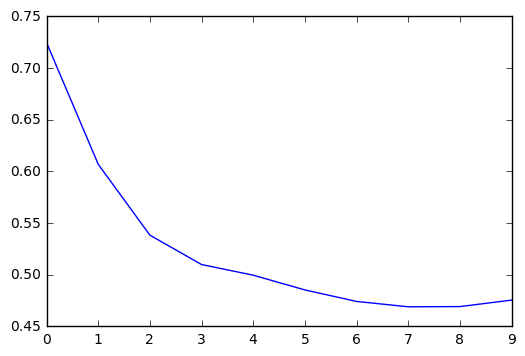

In [4]:
from progressbar import ProgressBar
def train(model, train_x_bond, train_x_atom, train_y, valid_x_bond, valid_x_atom, valid_y):
    n_epoch = 10
    loss_list = []
    for ii in range(n_epoch):
        print ('Training epoch: {0}'.format(ii))
        bar = ProgressBar(max_value=len(train_x_bond))
        for x_bond, x_atom, y in bar(zip(train_x_bond, train_x_atom, train_y)):
        #for x_bond, x_atom, y in zip(train_x_bond, train_x_atom, train_y):
            x_bond = x_bond[np.newaxis, :]
            x_atom = x_atom[np.newaxis, :]
            y = y[np.newaxis, :]
            model.train_on_batch([x_bond, x_atom], y)

        tmp_loss_list = []
        for x_bond, x_atom, y in zip(valid_x_bond, valid_x_atom, valid_y):
            x_bond = x_bond[np.newaxis, :]
            x_atom = x_atom[np.newaxis, :]
            y = y[np.newaxis, :]
            loss, metric = model.test_on_batch([x_bond, x_atom], y)
            tmp_loss_list.append(loss)
        loss = np.mean(tmp_loss_list)
        print ('loss: {0}'.format(loss))
        loss_list.append(loss)

    return loss_list

loss_list = train(model, train_x_bond, train_x_atom, train_y, valid_x_bond, valid_x_atom, valid_y)
import matplotlib.pyplot as plt
plt.plot(loss_list)
plt.show()

### evaluate model

In [6]:
def evaluate(model, valid_x_bond, valid_x_atom, valid_y):
    pred_list = []
    for x_bond, x_atom in zip(valid_x_bond, valid_x_atom):
        x_bond = np.asarray(x_bond)[np.newaxis, :]
        x_atom = np.asarray(x_atom)[np.newaxis, :]
        pred = model.predict_on_batch([x_bond, x_atom])
        pred_list.append(pred)

    pred = np.asarray(pred_list)[:, 0, :]

    from Teemo.algorithm.utils.evaluations import classification_evaluate
    from Teemo.algorithm.utils.report_funcs import classification_report
    res = classification_evaluate(pred, np.asarray(valid_y))
    print (classification_report(res))


evaluate(model, valid_x_bond, valid_x_atom, valid_y)

            precision   recall      f_measure   support     
class 0     0.7857      0.7857      0.7857      14          
class 1     0.5         0.5         0.5         6           
avg/total   0.7         0.7         0.7         20          
matrix
            Pred        
True        class 0     class 1     
class 0     11          3           
class 1     3           3           



In [7]:
model.summary()
evaluate(model, valid_x_bond, valid_x_atom, valid_y)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_1 (Embedding)          (None, None, 200)     4600                                         
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, None, 200)     20000                                        
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, None, 150)     330600      merge_1[0][0]                    
____________________________________________________________________________________________________
lstm_2 (LSTM)                    (None, None, 150)     180600      lstm_1[0][0]                     
___________________________________________________________________________________________

### model.get_config(), model.to_json(), model.to_yaml()
only the model's architecture is copied which can be used to reinstantiate a new model (who's weights/biases are reinitialized randomly)

In [8]:
### only copy the configuration of the model, and do not contain the weights/biases
config = model.get_config()
model_2 = Sequential.from_config(config) # weights/biases of "model_2" are re-initialized
evaluate(model_2, valid_x_bond, valid_x_atom, valid_y)

            precision   recall      f_measure   support     
class 0     0.7143      0.7143      0.7143      14          
class 1     0.3333      0.3333      0.3333      6           
avg/total   0.6         0.6         0.6         20          
matrix
            Pred        
True        class 0     class 1     
class 0     10          4           
class 1     4           2           



In [9]:
from keras.models import model_from_json
### only copy the configuration of the model, and do not contain the weights/biases
json_string = model.to_json()
model_3 = model_from_json(json_string) # weights/biases of "model_3" are re-initialized
evaluate(model_3, valid_x_bond, valid_x_atom, valid_y)

            precision   recall      f_measure   support     
class 0     0.6471      0.7857      0.7097      14          
class 1     0.0         0.0         0.0         6           
avg/total   0.4529      0.55        0.4968      20          
matrix
            Pred        
True        class 0     class 1     
class 0     11          3           
class 1     6           0           



In [10]:
from keras.models import model_from_yaml
yaml_string = model.to_yaml()
model_4 = model_from_yaml(yaml_string)
evaluate(model_4, valid_x_bond, valid_x_atom, valid_y)

            precision   recall      f_measure   support     
class 0     0.75        0.4286      0.5455      14          
class 1     0.3333      0.6667      0.4444      6           
avg/total   0.625       0.5         0.5152      20          
matrix
            Pred        
True        class 0     class 1     
class 0     6           8           
class 1     2           4           



In [11]:
weights_file = './weights_file.dat'
model.save_weights(weights_file)

In [12]:
model_4.load_weights(weights_file)

In [13]:
evaluate(model_4, valid_x_bond, valid_x_atom, valid_y)

            precision   recall      f_measure   support     
class 0     0.7857      0.7857      0.7857      14          
class 1     0.5         0.5         0.5         6           
avg/total   0.7         0.7         0.7         20          
matrix
            Pred        
True        class 0     class 1     
class 0     11          3           
class 1     3           3           

